In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from typing import Tuple, Union
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import solve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

import scipy

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def plot_logit_results(df, pred_key, ax, suptitle, grid=False, error_key=None, pred_min=0, pred_max=1, error_min=0.1, error_max=0.2):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                #norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if (error_key == None):
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size=error_key, #size_norm = (0.1, 0.2), sizes=(10, 200),
                            palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [4]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25

load_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nxMC_200_nr1MC_100"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

X_test = test_data[[x1_key, x2_key]]
Y_test = test_data["class"]

X_grid = grid_data[[x1_key, x2_key]]

In [5]:
# https://www.geeksforgeeks.org/gaussian-process-classification-gpc-on-iris-dataset/

grid_dfs = [0]*(len(n_data))
test_dfs = [0]*(len(n_data))
ls = 0.2  #Length scale
ov = 0.5 #Output variance

if load_values==False:
    for i in tqdm(range(len(n_data))):
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        X_train = train_data[[x1_key, x2_key]][0:n_data[i]]
        Y_train = train_data["class"][0:n_data[i]]
        
        kernel = ov * RBF(length_scale=ls)  # RBF kernel with default parameters
        gp = GaussianProcessClassifier(kernel=kernel)

        print(len(X_train))
        gp.fit(X_train, Y_train)
        test_dfs[i]["Est_prob_blue"] = gp.predict_proba(X_test)[:,1]
        test_dfs[i]["Prediction"] = gp.predict(X_test)
        grid_dfs[i]["Est_prob_blue"] = gp.predict_proba(X_grid)[:,1]
        grid_dfs[i]["Prediction"] = gp.predict(X_grid)
        
        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
        test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_GP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_GP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_GP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_GP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")

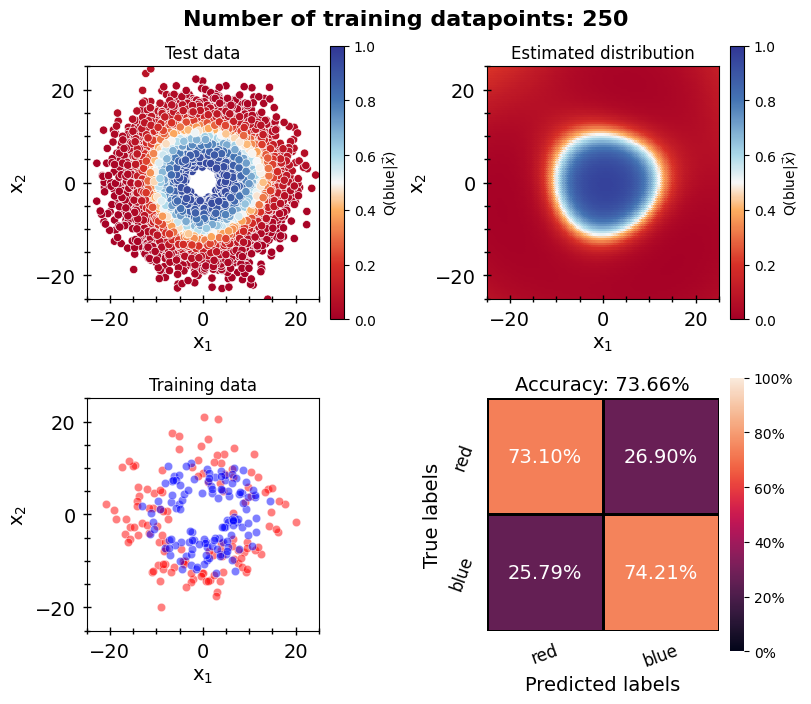

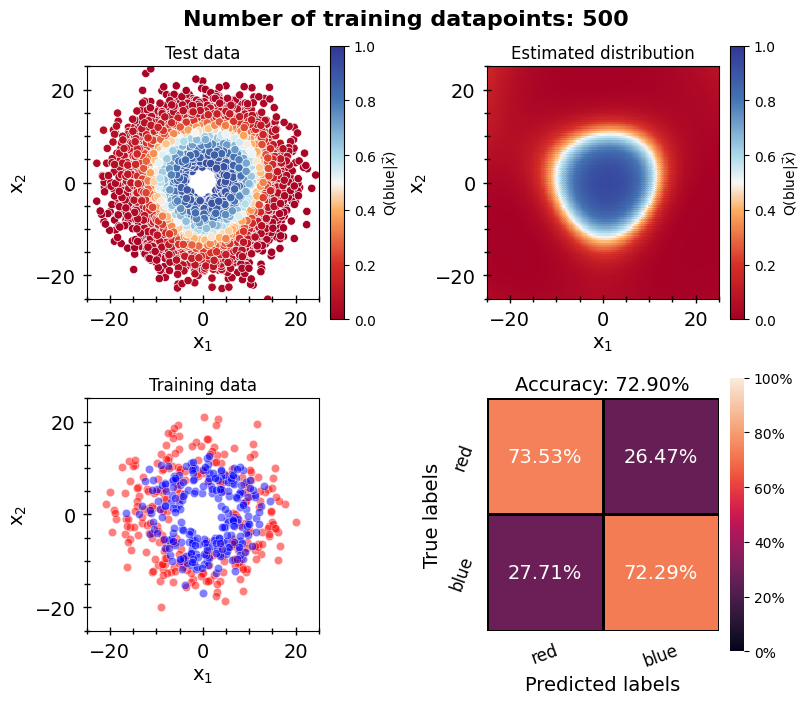

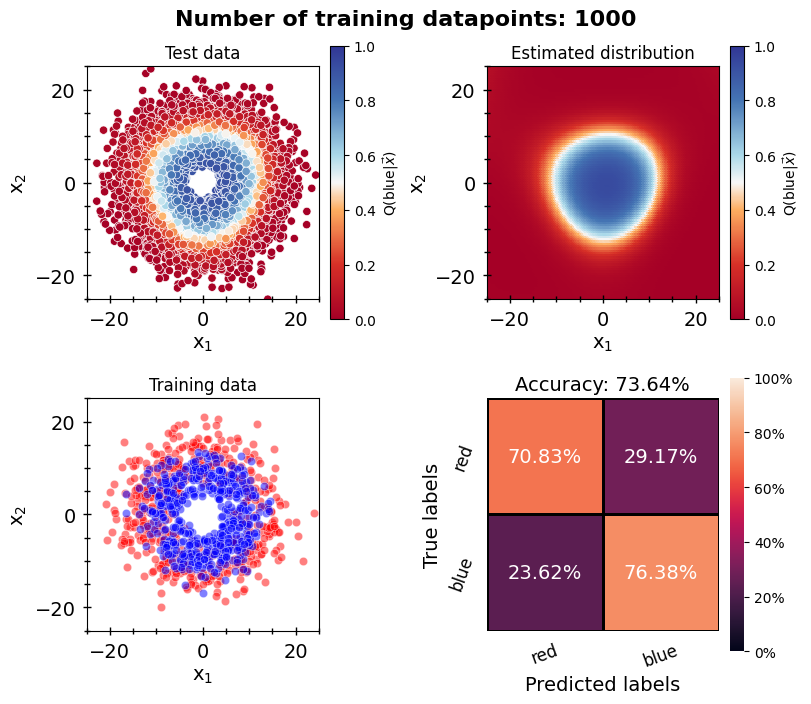

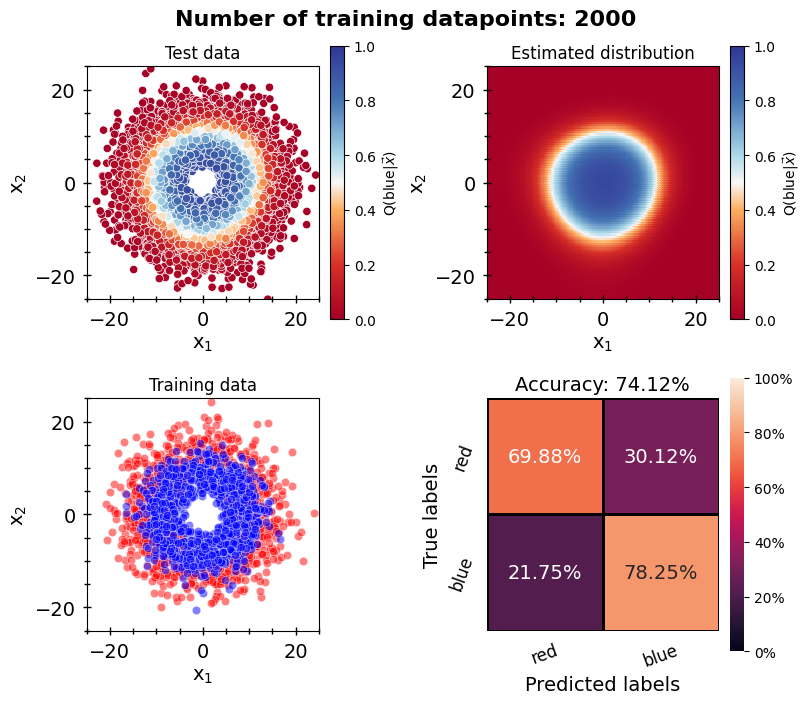

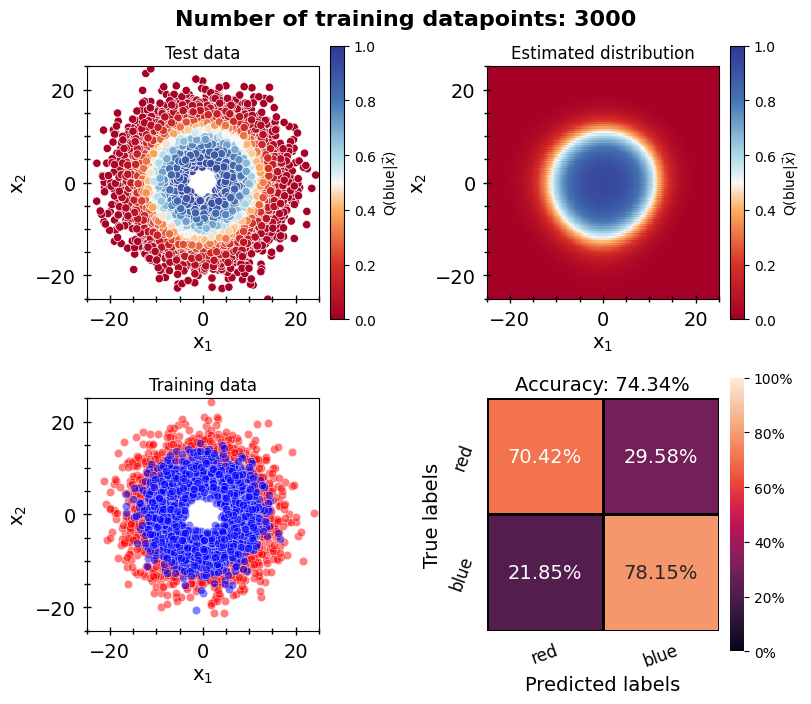

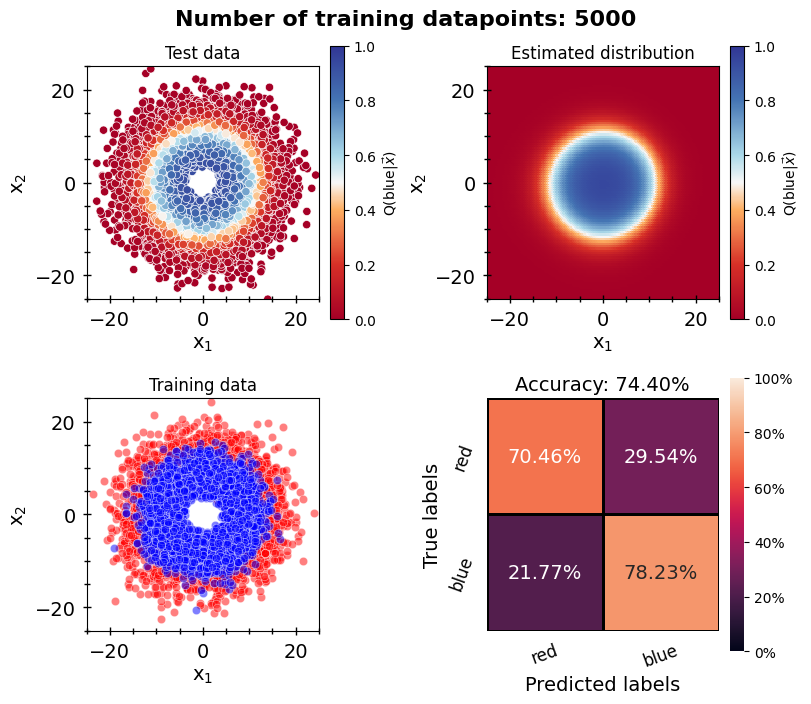

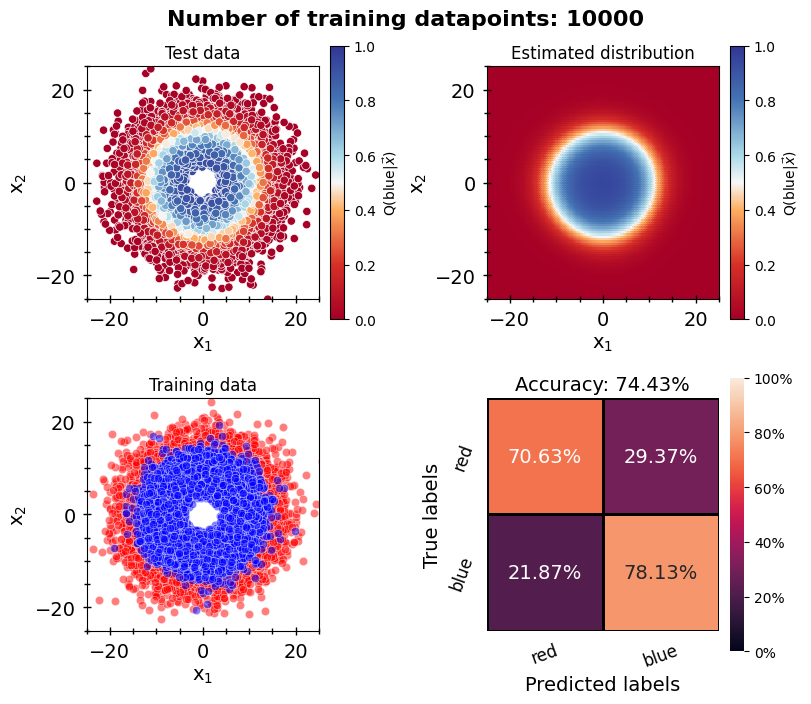

In [6]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data")
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

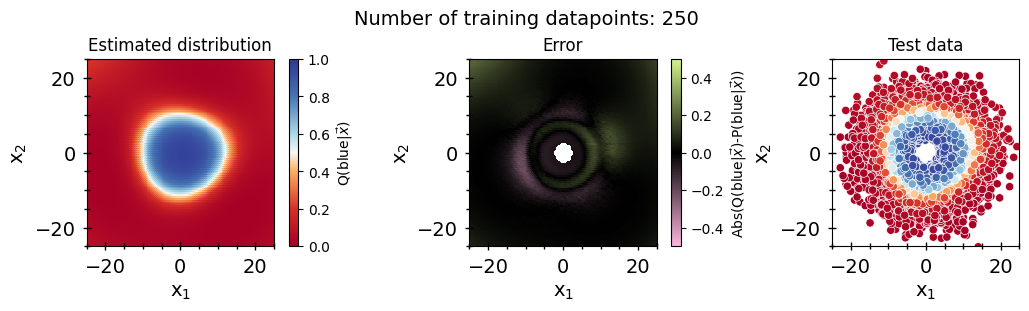

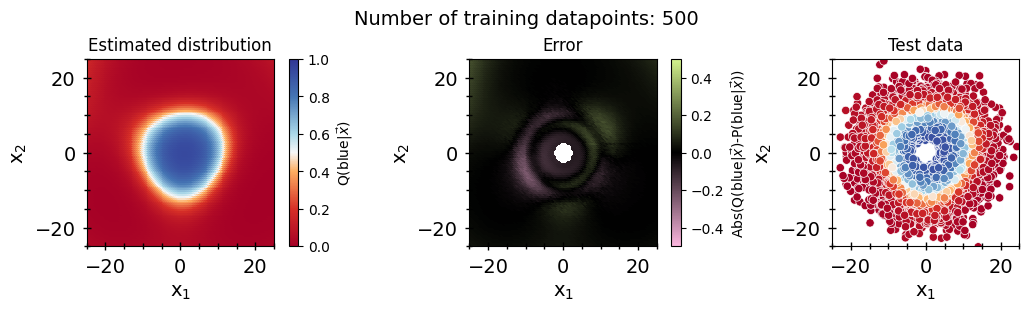

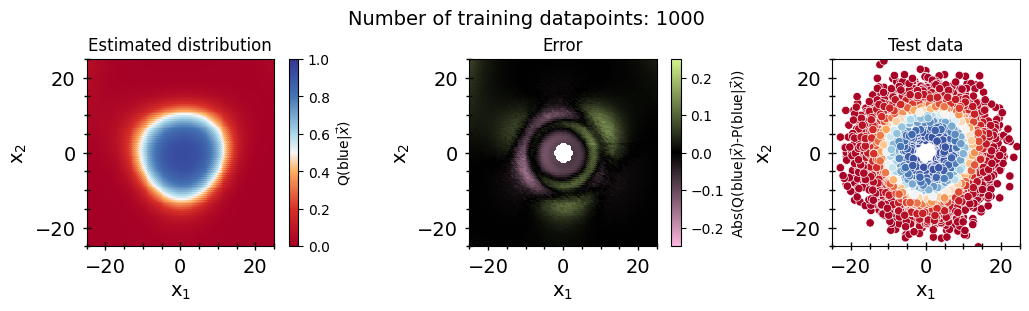

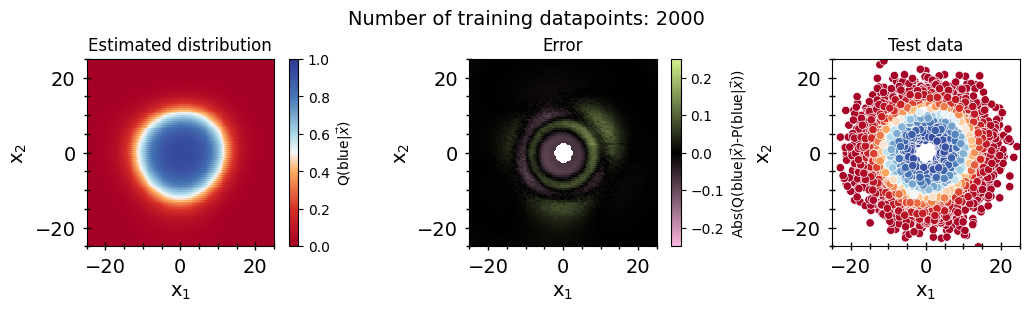

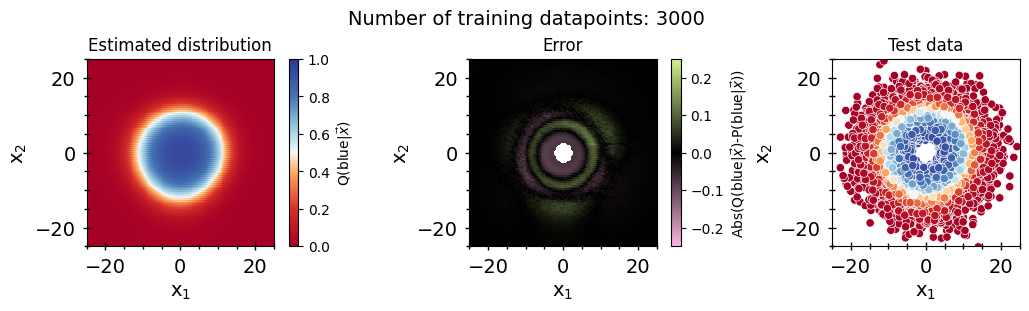

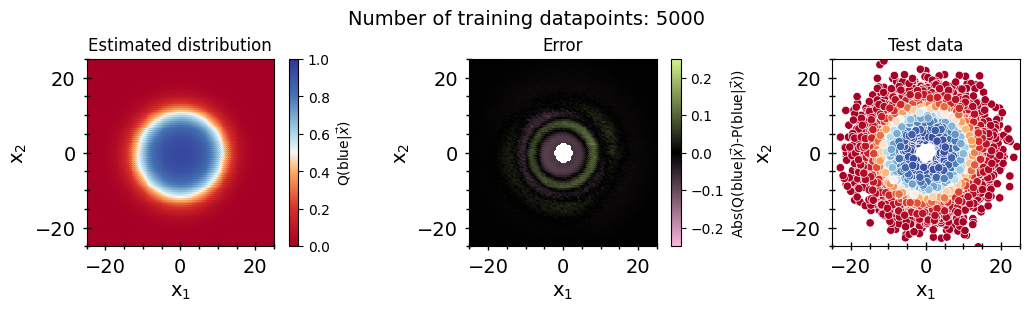

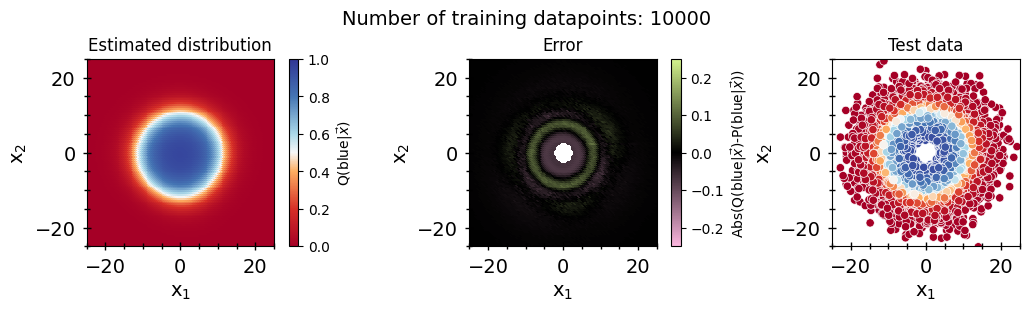

In [7]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "Est_prob_blue", "P_blue_given_x", axs[1], r"Error", max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_results(test_dfs[i], "Est_prob_blue", axs[2], "Test data")

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


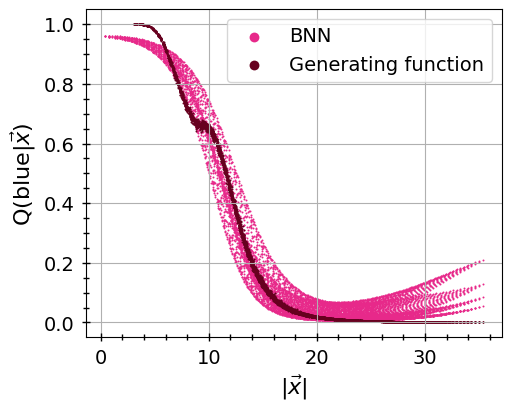

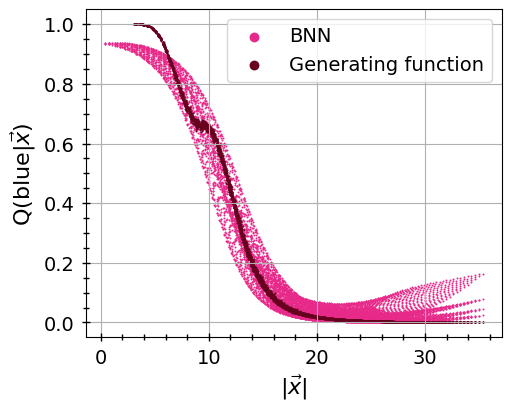

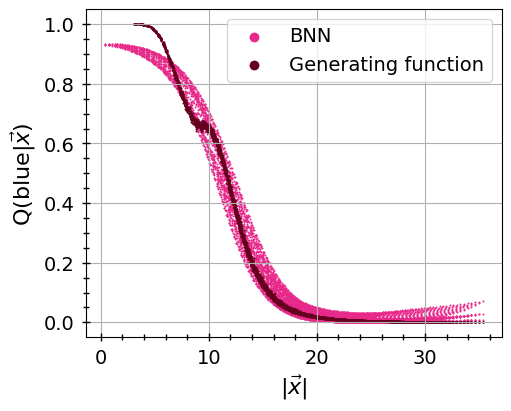

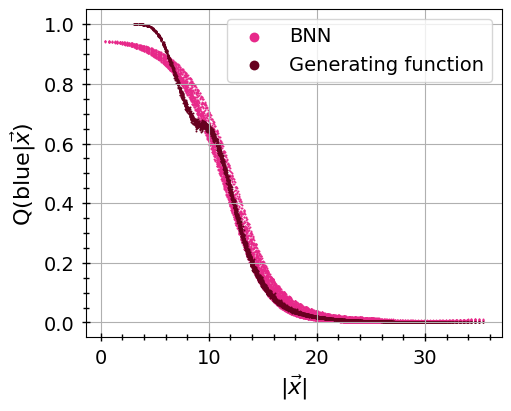

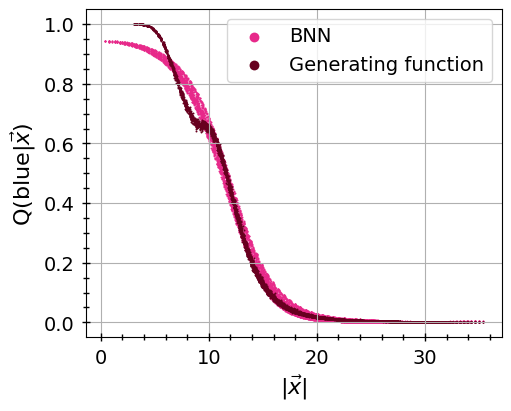

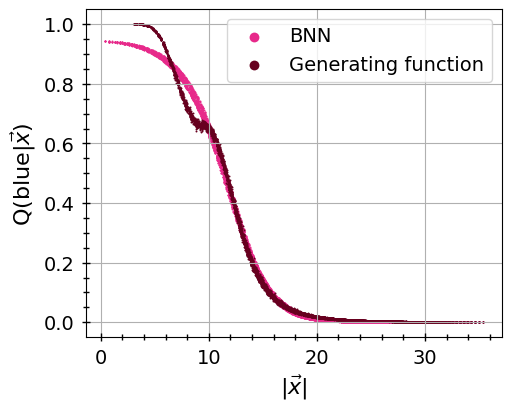

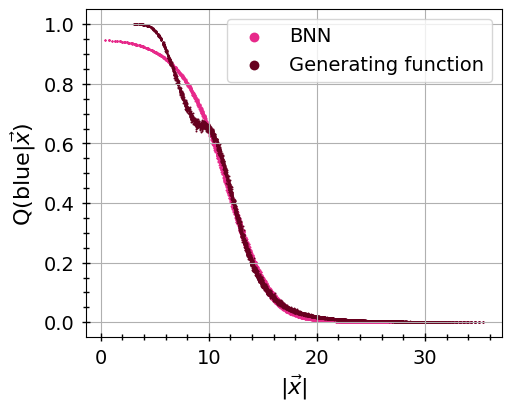

In [8]:
for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Est_prob_blue", s=2, ax = ax, label="BNN", color="#e7298a", linewidth=0)
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function", color="#67001f", linewidth=0)
    ax.set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()

In [9]:
keys = ["N data"]
scores = pd.DataFrame(columns=keys)
scores["N data"] = n_data
n_plots = len(n_data)
scores["ACC"] = [accuracy_score(test_dfs[i]["class"], test_dfs[i]["Prediction"], normalize=True) for i in range(n_plots)]
scores["ROCAUC"] = [roc_auc_score(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"]) for i in range(n_plots)]
scores["WD test"] = [wasserstein_distance(truth_test_data["P_blue_given_x"], test_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]
scores["WD grid"] = [wasserstein_distance(truth_data["P_blue_given_x"], grid_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]
#scores["Avg UE"] = [test_dfs[i]["Std_prob_blue"].mean() for i in range(n_plots)]
#scores["Std UE"] = [test_dfs[i]["Std_prob_blue"].std() for i in range(n_plots)]
scores["Mean KL-div test"] = [kl_div(truth_test_data["P_blue_given_x"], test_dfs[i]["Est_prob_blue"]).mean() for i in range(len(n_data))]
scores["Mean KL-div grid"] = [kl_div(truth_data["P_blue_given_x"], grid_dfs[i]["Est_prob_blue"]).mean() for i in range(len(n_data))]
scores["LogLoss"] = [log_loss(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]

print(scores)

   N data     ACC    ROCAUC   WD test   WD grid  Mean KL-div test  \
0     250  0.7366  0.815383  0.039091  0.028026          0.007835   
1     500  0.7290  0.811827  0.036590  0.024442          0.008107   
2    1000  0.7364  0.816750  0.031645  0.017976          0.004362   
3    2000  0.7412  0.819786  0.030457  0.016834          0.002506   
4    3000  0.7434  0.820776  0.029028  0.015467          0.001736   
5    5000  0.7440  0.821624  0.028121  0.015527          0.001290   
6   10000  0.7443  0.821943  0.027980  0.015472          0.001290   

   Mean KL-div grid   LogLoss  
0          0.016633  0.522690  
1          0.012127  0.526232  
2          0.004773  0.518395  
3          0.001946  0.514488  
4          0.001505  0.513104  
5          0.002116  0.512016  
6          0.002424  0.511505  


### Uncertainties in Gaussian Processes

In [10]:


#https://stackoverflow.com/questions/67818319/how-to-output-mean-and-stdv-of-gaussian-process-classifier-in-sklearn
class LatentGPC(GaussianProcessClassifier):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def predict_a(
        self, X: np.ndarray, return_std: bool = False
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Return estimates of the latent function for X.
        
        Notes:
        ------
        - For binary classification (n_classes = 2), the output shape is
        (n_samples,).
        - For multi-class classification, the output shape is (n_samples,
        n_classes) when multi_class="one_vs_rest", and is shaped (n_samples,
        n_classes*(n_classes - 1)/2) when multi_class="one_vs_one". In other
        terms, There are as many columns as trained Binary GPC sub-models.
        - The number of classes (n_classes) is determined by the number of
        unique target values in the training data.
        """
        check_is_fitted(self)

        if self.n_classes_ > 2:  # Multi-class case
            f_stars = []
            std_f_stars = []
            for estimator, kernel in zip(self.base_estimator_.estimators_, self.kernel_.kernels):
                result = self._binary_predict_a(estimator, kernel, X, return_std)
                if not return_std:
                    f_stars.append(result)
                else:
                    f_stars.append(result[0])
                    std_f_stars.append(result[1])

            if not return_std:
                return np.array(f_stars).T

            return np.array(f_stars).T, np.array(std_f_stars).T
        else:  # Binary case
            return self._binary_predict_a(self.base_estimator_, self.kernel_, X, return_std)

    @staticmethod
    def _binary_predict_a(estimator, kernel, X, return_std):
        """ Return mean and std of the latent function estimates for X. """
        check_is_fitted(estimator)

        # Based on Algorithm 3.2 of GPML
        K_star = kernel(estimator.X_train_, X)  # K_star = k(x_star)
        f_star = K_star.T.dot(estimator.y_train_ - estimator.pi_)  # Line 4
        if not return_std:
            return f_star

        v = solve(estimator.L_, estimator.W_sr_[:, np.newaxis] * K_star)  # Line 5
        # Line 6 (compute np.diag(v.T.dot(v)) via einsum)
        var_f_star = kernel.diag(X) - np.einsum("ij,ij->j", v, v)

        return f_star, np.sqrt(var_f_star)
    

def predictive_prob(mf, stdf):
    """Approximation to int sigma(f) N(f|mf,stdf**2) df
    where sigma is the logistic function and N is a Gaussian
    By David JC MacKay, 1992"""
    f_transform = mf/np.sqrt(1.0 + np.pi * stdf / 8.0)
    
    return (1/(1+np.exp(-f_transform)))



In [11]:
# https://www.geeksforgeeks.org/gaussian-process-classification-gpc-on-iris-dataset/

grid_latent_dfs = [0]*(len(n_data))
test_latent_dfs = [0]*(len(n_data))
ls = 0.2  #Length scale
ov = 0.5 #Output variance

if load_values==False:
    for i in tqdm(range(len(n_data))):
        grid_latent_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_latent_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        X_train = train_data[[x1_key, x2_key]][0:n_data[i]]
        Y_train = train_data["class"][0:n_data[i]]
        
        kernel = ov * RBF(length_scale=ls)  # RBF kernel with default parameters
        gp = LatentGPC(kernel=kernel)

        print(len(X_train))
        gp.fit(X_train, Y_train)
        test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_test, return_std=True)
        test_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Logit_blue"]))
        test_latent_dfs[i]["Prediction"] = gp.predict(X_test)

        grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_grid, return_std=True)
        grid_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Logit_blue"]))
        grid_latent_dfs[i]["Prediction"] = gp.predict(X_grid)
        
        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
        test_latent_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_latent_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")

In [12]:
grid_latent_dfs[0]

Unnamed: 0.1  Unnamed: 0         x1    x2        r_x       a_x  \
0                0           0 -25.000000 -25.0  35.355339  3.926991   
1                1           1 -24.494949 -25.0  35.000036  3.937195   
2                2           2 -23.989899 -25.0  34.648452  3.947606   
3                3           3 -23.484848 -25.0  34.300701  3.958231   
4                4           4 -22.979798 -25.0  33.956901  3.969071   
...            ...         ...        ...   ...        ...       ...   
9995          9995        9995  22.979798  25.0  33.956901  0.827479   
9996          9996        9996  23.484848  25.0  34.300701  0.816638   
9997          9997        9997  23.989899  25.0  34.648452  0.806014   
9998          9998        9998  24.494949  25.0  35.000036  0.795602   
9999          9999        9999  25.000000  25.0  35.355339  0.785398   

      Logit_blue  Std_logit_blue  Sigmoid_blue  Prediction  
0      -7.984839        5.525324      0.000340           0  
1      -8.008837        5.439214      0.000332           0  
2      -8.027018        5.352645      0.000326           0  
3      -8.039435        5.265725      0.000322           0  
4      -8.046159        5.178563      0.000320           0  
...          ...             ...           ...         ...  
9995   -6.954294        5.172897      0.000954           0  
9996   -6.861596        5.250826      0.001046           0  
9997   -6.766120        5.328801      0.001151           0  
9998   -6.668027        5.406738      0.001269           0  
9999   -6.567481        5.484553      0.001403           0  

[10000 rows x 10 columns]

In [13]:
for i in range(len(n_data)):
    test_latent_dfs[i]["Est_prob_blue"] = predictive_prob(test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"])
    grid_latent_dfs[i]["Est_prob_blue"] = predictive_prob(grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"])
    test_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
    grid_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive

In [14]:
test_latent_dfs[0]

Unnamed: 0 color         x1         x2        a1        a2         r1  \
0              0   red   4.637181  11.350187  0.935784  1.553757  11.837233   
1              1   red  10.042744  10.382106  0.682262  0.612850  11.887063   
2              2  blue  -5.605532  11.920284  1.943990  0.295500  10.273541   
3              3  blue  -1.477669 -14.679668  4.577589  0.170343  11.788505   
4              4  blue  -9.945727   8.379890  2.213879  1.781017  13.296149   
...          ...   ...        ...        ...       ...       ...        ...   
9995        9995   red   0.596807   9.253463  1.318706  2.526894  11.560692   
9996        9996  blue  -6.404741   6.863661  1.997287  1.496279   8.674995   
9997        9997  blue -11.277142   2.093363  2.757517  0.865739   9.295702   
9998        9998   red   8.927445  11.836816  0.898653  3.012991  17.796208   
9999        9999  blue  -3.594322  -8.356490  4.193690  2.794252  11.860049   

      r2        r_x       a_x  class  Logit_blue  Std_logit_blue  \
0      3  12.260921  1.182936      0   -0.702272        0.499413   
1      3  14.444543  0.802012      0   -1.428084        0.660287   
2      3  13.172515  2.010363      1   -0.962873        0.637090   
3      3  14.753853  4.612066      1   -2.003610        0.628771   
4      3  13.005386  2.441433      1   -0.902335        0.587555   
...   ..        ...       ...    ...         ...             ...   
9995   3   9.272689  1.506390      0    0.803259        0.379762   
9996   3   9.387787  2.321621      1    0.769206        0.405600   
9997   3  11.469791  2.958053      1   -0.633633        0.445537   
9998   3  14.825974  0.924606      0   -1.852148        0.739060   
9999   3   9.096707  4.306187      1    0.837395        0.337634   

      Sigmoid_blue  Prediction  Est_prob_blue  Sigmoid_std_logit_blue  
0         0.331309           0       0.344767                0.122321  
1         0.193397           0       0.218813                0.159325  
2         0.276303           0       0.297098                0.154095  
3         0.118824           0       0.142547                0.152211  
4         0.288571           0       0.307174                0.142804  
...            ...         ...            ...                     ...  
9995      0.690671           1       0.679032                0.093816  
9996      0.683349           1       0.671375                0.100032  
9997      0.346687           0       0.357885                0.109578  
9998      0.135621           0       0.163751                0.176790  
9999      0.697916           1       0.687156                0.083616  

[10000 rows x 17 columns]

## Not properly normalized

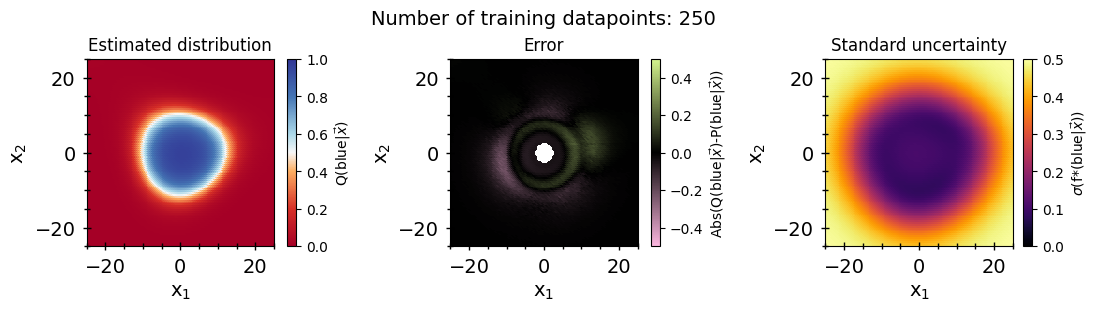

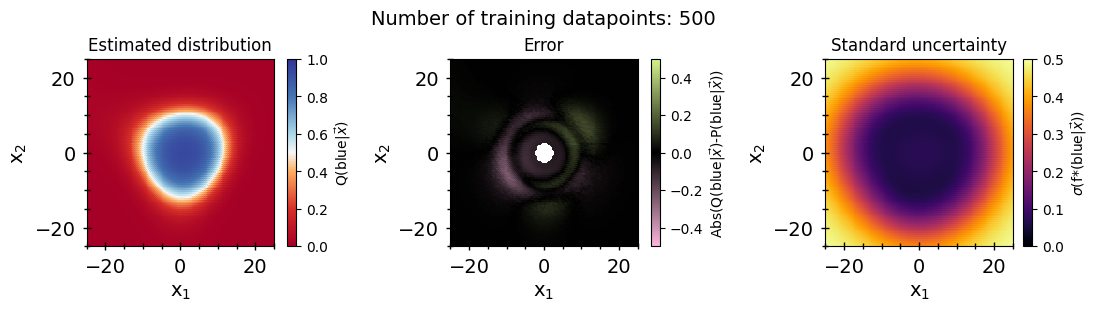

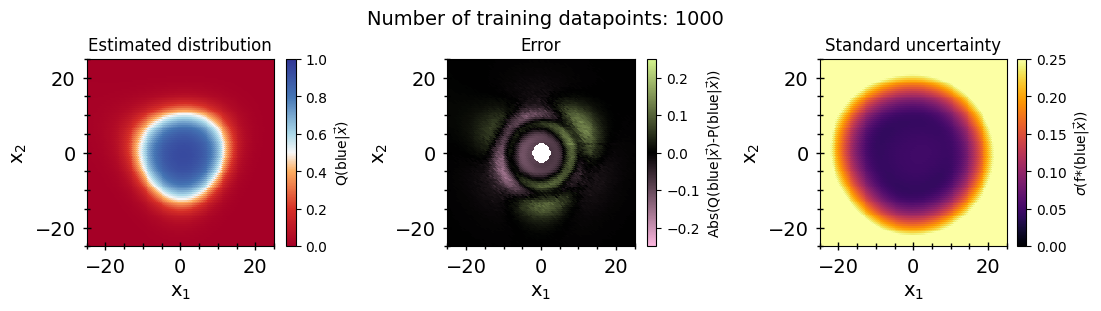

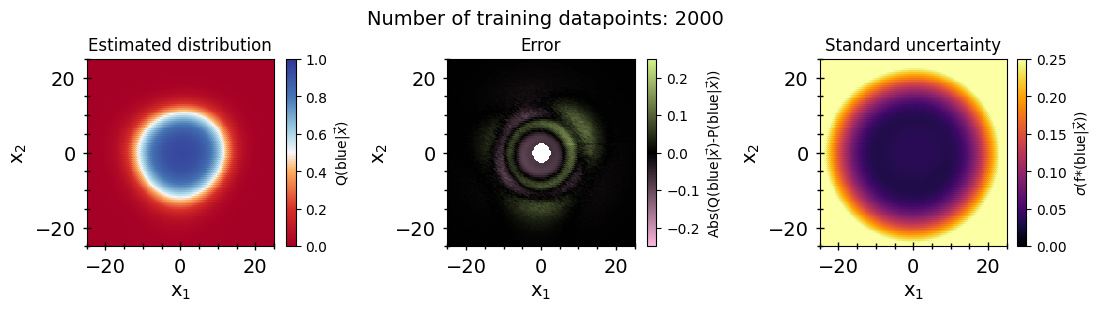

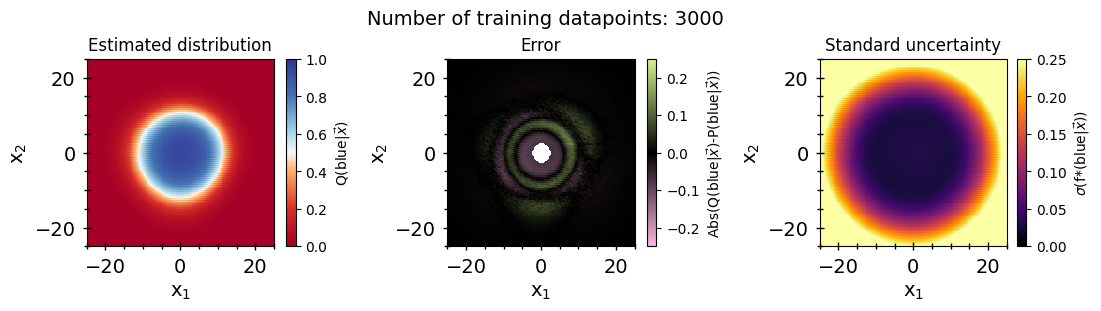

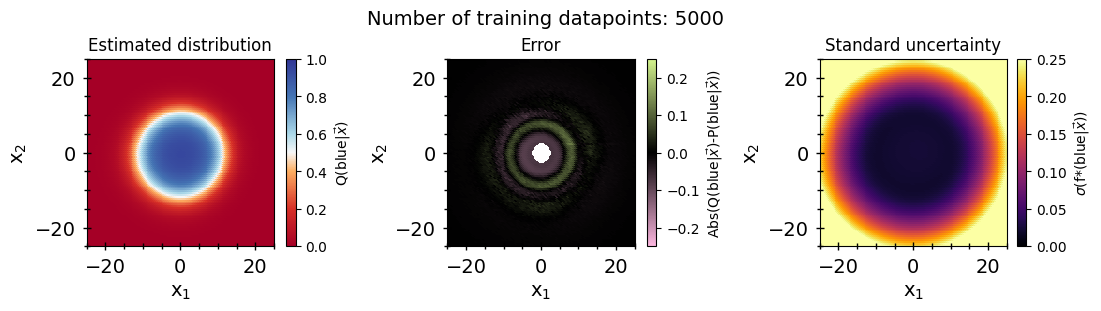

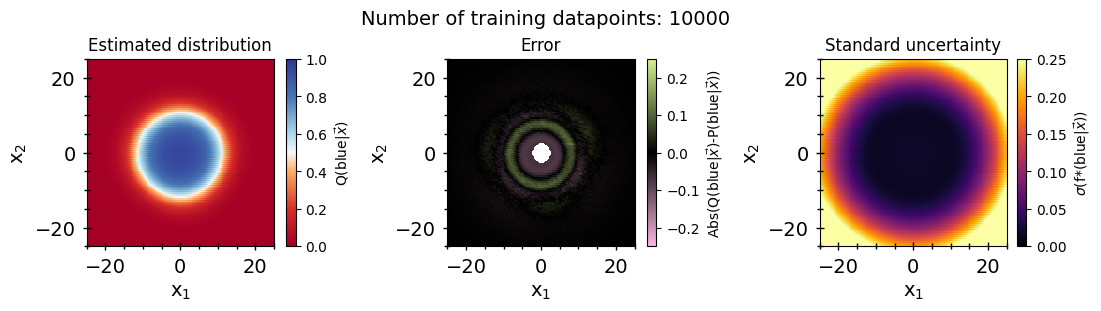

In [15]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_latent_dfs[i], "Sigmoid_blue", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_latent_dfs[i], truth_data, "Sigmoid_blue", "P_blue_given_x", axs[1], r"Error", max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_latent_dfs[i], "Sigmoid_std_logit_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(f*(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


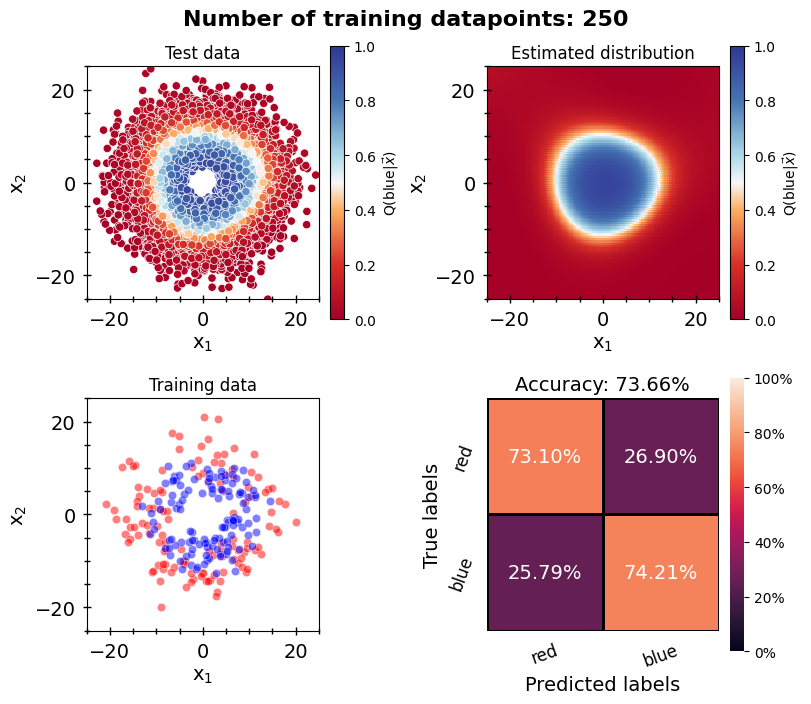

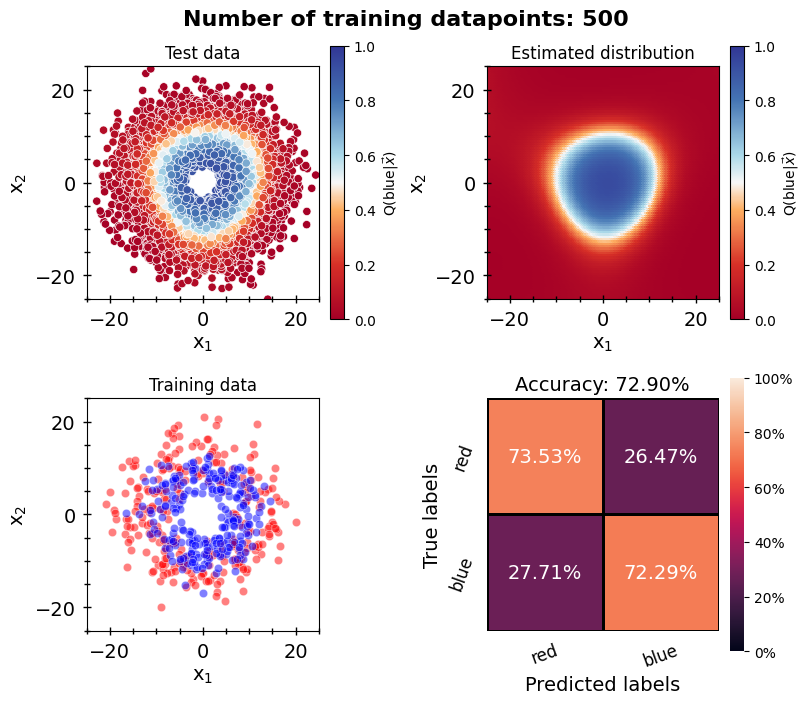

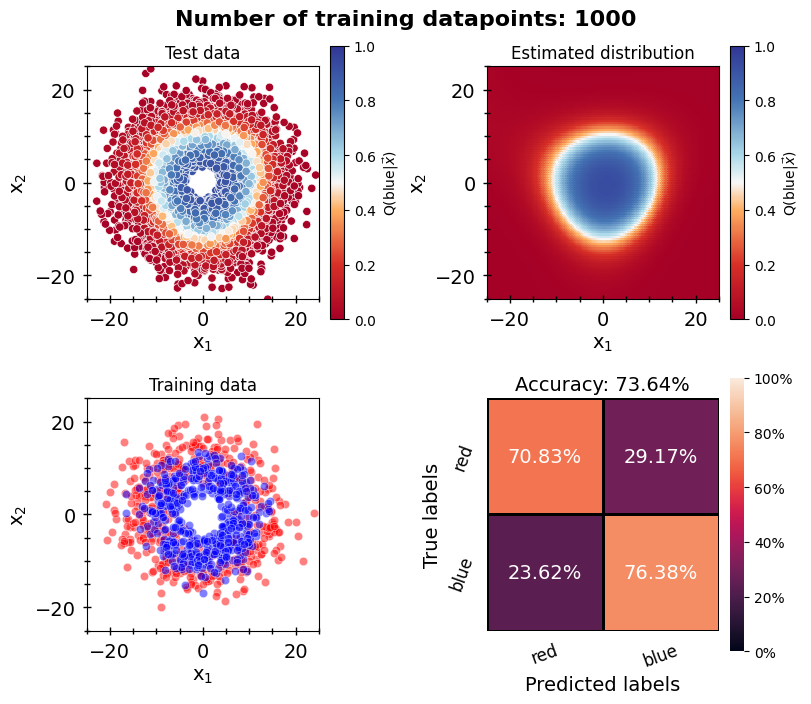

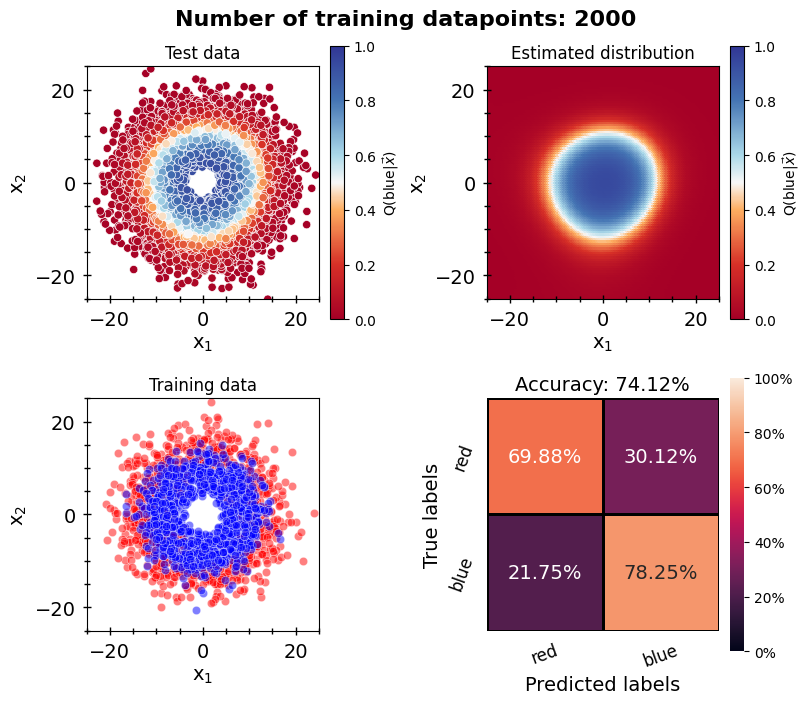

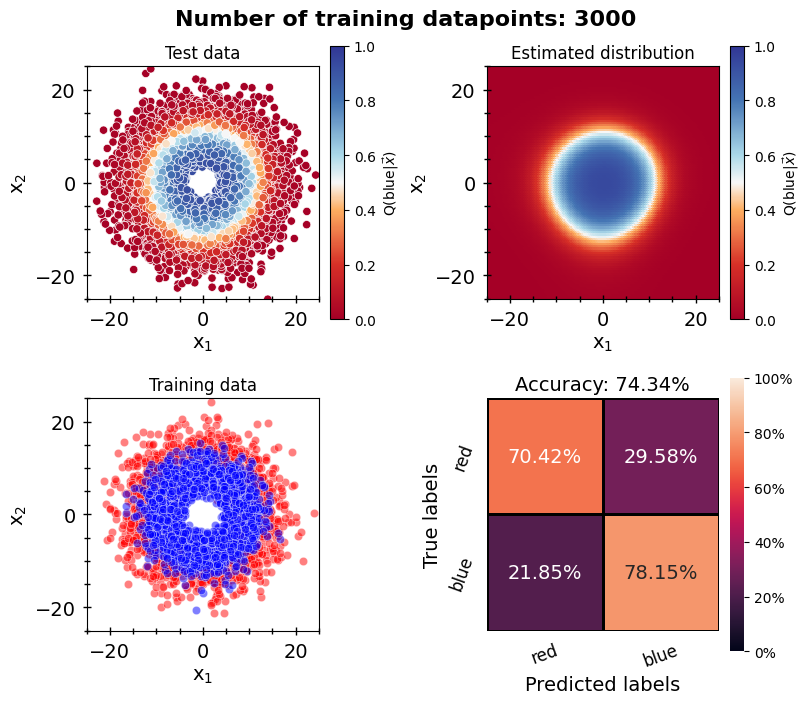

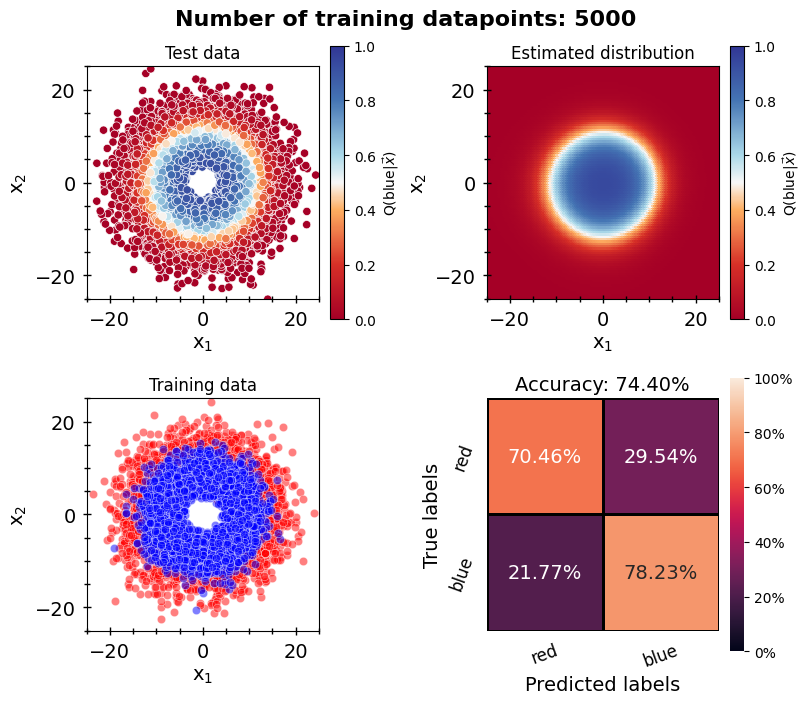

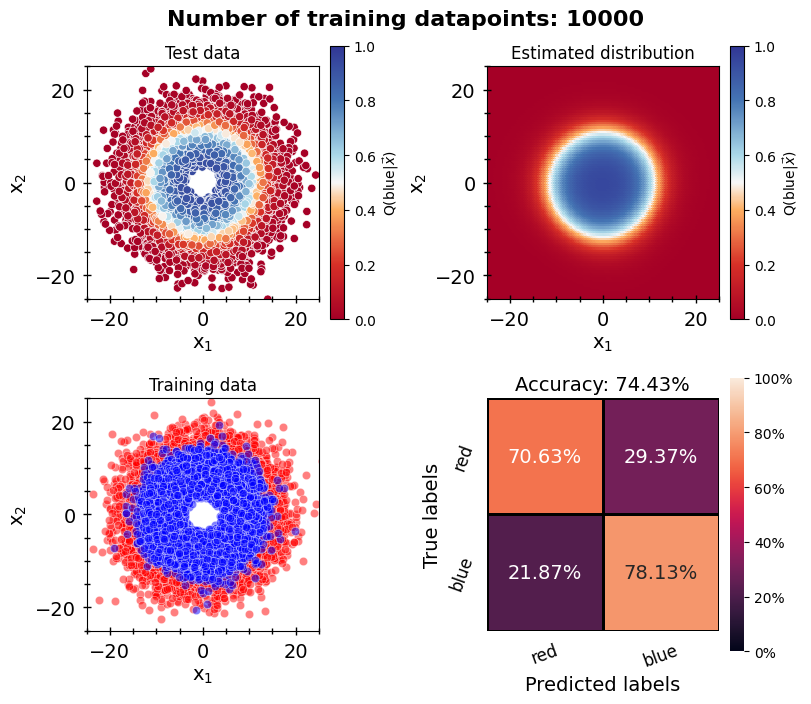

In [16]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    axs[0][0] = plot_results(test_latent_dfs[i], "Est_prob_blue", axs[0][0], "Test data")
    axs[0][1] = plot_results(grid_latent_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_latent_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

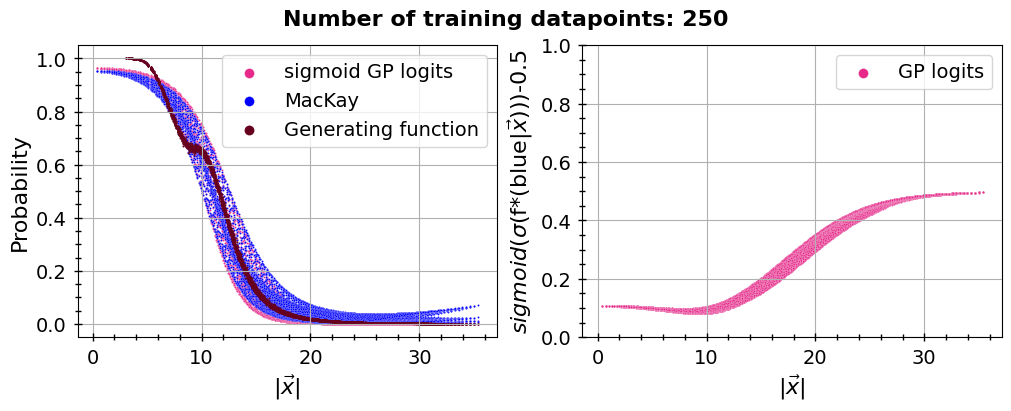

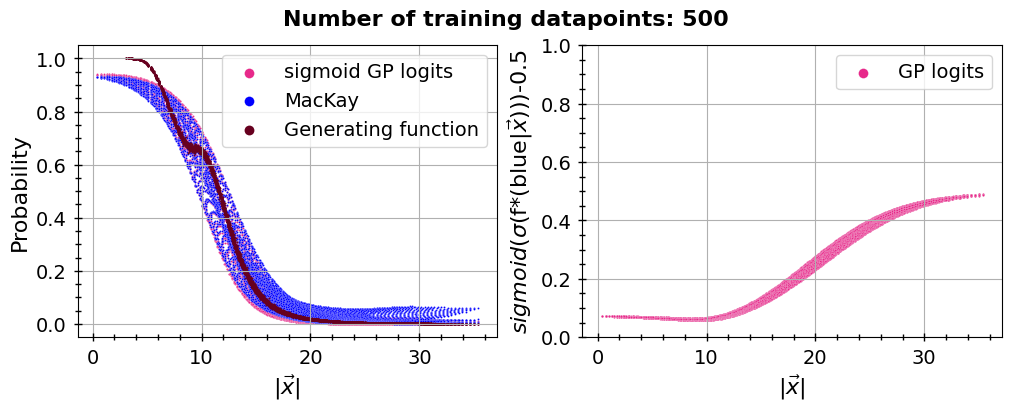

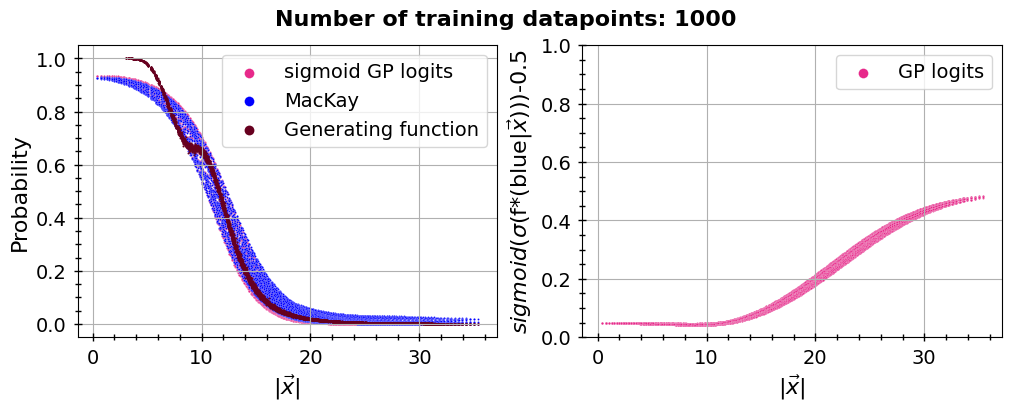

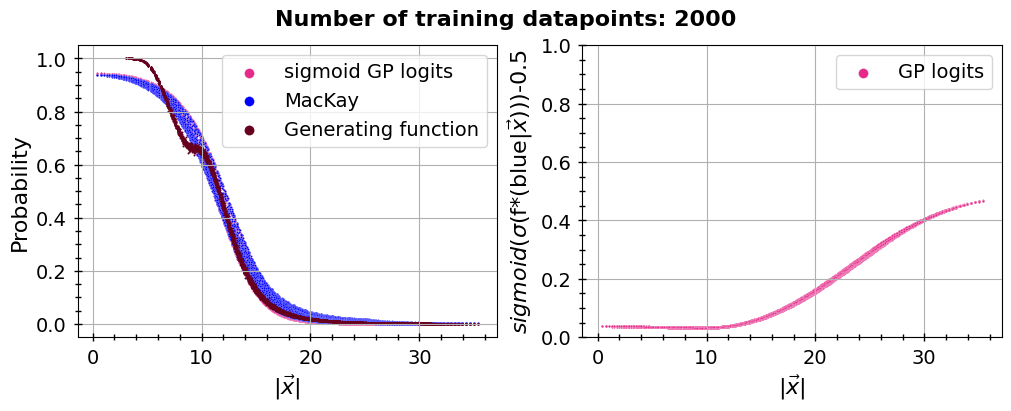

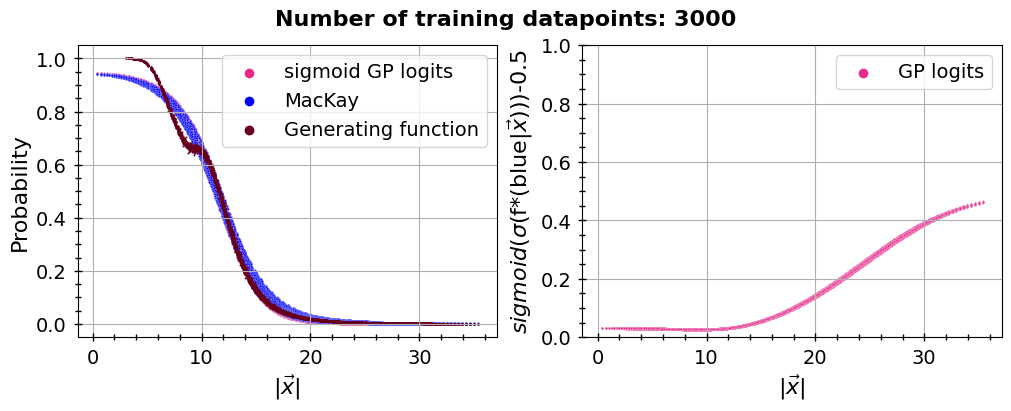

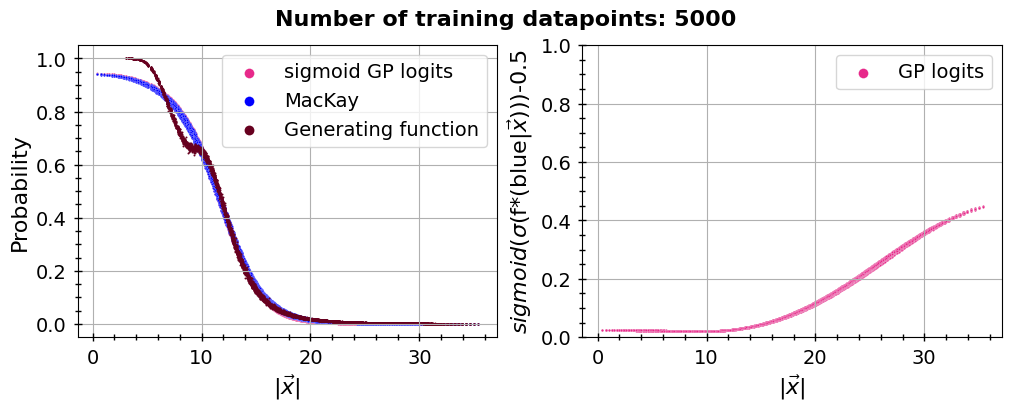

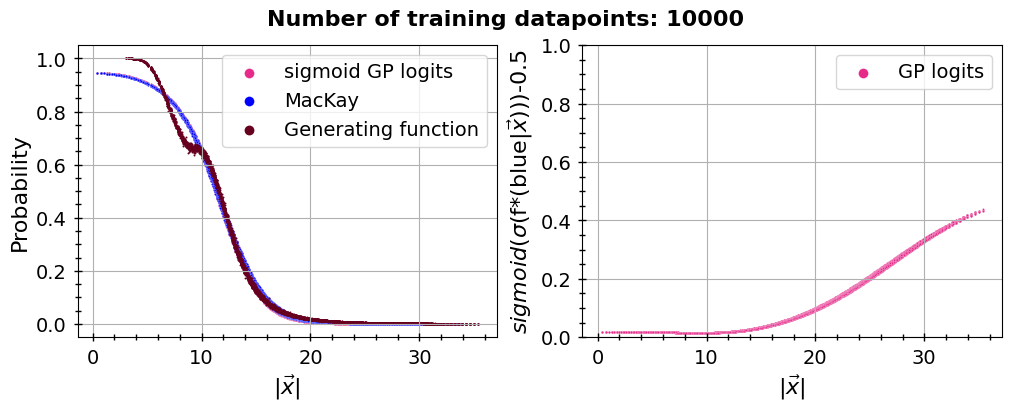

In [21]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Sigmoid_blue", s=2, ax = axs[0], label="sigmoid GP logits", color="#e7298a")
    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Est_prob_blue", s=2, ax = axs[0], label="MacKay", color="blue")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Probability", fontsize=16)

    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Sigmoid_std_logit_blue", s=2, ax = axs[1], label="GP logits", color="#e7298a")
    axs[1].set_ylabel(r"$sigmoid(\sigma$(f*(blue|$\vec{x}$)))-0.5", fontsize=16)
    axs[1].set_ylim(0, 1)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [18]:
scores = calculate_metrics(test_latent_dfs, grid_latent_dfs, n_data, truth_data, truth_test_data, 
                           "Prediction", "Est_prob_blue", "Sigmoid_std_logit_blue")

print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.7366  0.815503  0.036714  0.018003  0.128626  0.058925   
1     500  0.7290  0.811835  0.037475  0.022197  0.089381  0.046107   
2    1000  0.7364  0.816744  0.033507  0.019918  0.063907  0.037091   
3    2000  0.7412  0.819780  0.032075  0.019194  0.047614  0.030044   
4    3000  0.7434  0.820777  0.030205  0.016165  0.040428  0.027519   
5    5000  0.7440  0.821624  0.028838  0.015457  0.032046  0.023176   
6   10000  0.7443  0.821944  0.028264  0.015171  0.024274  0.019558   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.007136          0.007228  0.521745  0.037884  0.086121  0.045554  
1          0.007960          0.008394  0.526330  0.036751  0.079753  0.043219  
2          0.004615          0.004429  0.518993  0.031576  0.075775  0.037235  
3          0.002762          0.002170  0.514932  0.033175  0.063912  0.035522  
4          0.001869          0.